In [ ]:
!pip install snowflake-snowpark-python
!pip install googletrans

### Setup Connection

In [ ]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
from googletrans import Translator
from snowflake.snowpark.functions import year, month
from snowflake.snowpark.functions import col,sum as sum_
from snowflake.snowpark.functions import count, lit
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
connection_parameters = {
...    "account": "YEZEPEO-VNSHARED",
...    "user": "VNSHARED",
...    "password": "Stratify2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "VN_SHARED_DB" # optional
# ...    "schema": "your snowflake schema",  # optional
...  }

In [ ]:
new_session = Session.builder.configs(connection_parameters).create()

#### Join Vespucio and equifax data

In [ ]:
df_consolidated=new_session.table('PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
df_equifax=new_session.table('PUBLIC.EQUIFAX_SHARED')

In [ ]:
# Finding Common columns
common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# Printing common columns
print ("Common Columns:",common_cols)

Common Columns: ['"FechaExtraccion"' 'RUT']


In [ ]:
df_con_equifax=df_consolidated.join(df_equifax.select('"RUT"', '"Score Equifax"'), on='"RUT"', how='left').drop(df_equifax['"FechaExtraccion"'])

In [ ]:
df_con_equifax.columns

['RUT',
 '"NumeroDocumento"',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"']

In [ ]:
df_con_equifax.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"      |"NumeroDocumento"  |"NumeroFolio"  |"FechaEmision"  |"FechaVencimiento"  |"FechaRegistro"  |"BusinessPartnerId"  |"CuentaContrato"  |"Cl

In [ ]:
# Define the new column name for the second column
new_column_name = 'FechaExtraccion'

# Use withColumnRenamed to create a new DataFrame with the renamed column
df_con_equifax_v = df_con_equifax.withColumnRenamed(df_con_equifax.columns[1], new_column_name)

In [ ]:
df_con_equifax_v.columns

['RUT',
 'FECHAEXTRACCION',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"']

#### Shape of the datasets

In [ ]:
def dataset_shape(df):
    # Get the number of rows
    num_rows = df.count()
    # Get the number of columns
    num_columns = len(df.columns)
    # Shape of the DataFrame
    shape = (num_rows, num_columns)
    print("Shape of the given dataset", shape)

In [ ]:
dataset_shape(df_con_equifax_v)

Shape of the given dataset (482705441, 39)


In [ ]:
dataset_shape(df_equifax)

Shape of the given dataset (3537839, 7)


In [ ]:
dataset_shape(df_consolidated)

Shape of the given dataset (482705441, 39)


#### Missing Values

In [ ]:
def missing_values(df):
# Assuming 'df' is your DataFrame
    # Get the total number of rows
    total_rows = df.count()

    missing_percentages = df.select(
        [(100 - (count(c) / lit(total_rows) * 100)).alias(c) for c in df.columns]
    )

    # Show the results
    missing_percentages.show()

In [ ]:
missing_values(df_con_equifax_v)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"     |"FECHAEXTRACCION"  |"NumeroFolio"  |"FechaEmision"  |"FechaVencimiento"  |"FechaRegistro"  |"BusinessPartnerId"  |"CuentaContrato"  |"ClaveReconciliacion"  |"Cabecera_FechaHoraCreacion"

#### Drop unique identifiers from the joined dataset for EDA & visualization purposes

In [ ]:
# Or you can pass a list of columns:
columns_to_drop = ['"NumeroDocumento"', '"NumeroFolio"', '"BusinessPartnerId"', '"RUT"','"CuentaContrato"','"StatusCompensacionTmp"',
                      '"FechaRegistro"','"ClaveReconciliacion"','"Cabecera_FechaHoraCreacion"','"Detalle_FechaHoraCreacion"','"Direccion"','"Nombre"','FECHAEXTRACCION']
df_con_equifax_v_dropped = df_con_equifax_v.drop(*columns_to_drop)

In [ ]:
df_con_equifax_v_dropped.columns

['"FechaEmision"',
 '"FechaVencimiento"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraUltimaModificacion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"Score Equifax"']

In [ ]:
columns_to_drop2=['"Cabecera_FechaHoraUltimaModificacion"', '"Detalle_FechaHoraUltimaModificacion"']
df_con_equifax_v_dropped = df_con_equifax_v_dropped.drop(*columns_to_drop2)

In [ ]:
df_con_equifax_v_dropped.columns

['"FechaEmision"',
 '"FechaVencimiento"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"Score Equifax"']

In [ ]:
missing_values(df_con_equifax_v_dropped)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"  |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"TipoProducto"  |"StatusCompensacion"  |"Score Equifax"  |
----------------------------------------

In [ ]:
from snowflake.snowpark.functions import col, is_null
df_with_missing_values = df_con_equifax_v_dropped.where(is_null(col('"DiasCompensacion"')))

In [ ]:
df_with_missing_values.select('"StatusCompensacion"').distinct().collect()

[Row(StatusCompensacion='Impaga'),
 Row(StatusCompensacion='Pagada'),
 Row(StatusCompensacion='Castigado')]

In [ ]:
from snowflake.snowpark.functions import count

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_with_missing_values.groupBy('"StatusCompensacion"').agg(count("*").alias("count"))

# Show the results
count_distinct_types.show()

-----------------------------------
|"StatusCompensacion"  |"COUNT"   |
-----------------------------------
|Pagada                |69        |
|Castigado             |1         |
|Impaga                |47573682  |
-----------------------------------



In [ ]:
from snowflake.snowpark.functions import col, is_null

# List of columns to check for null values
columns_to_check = ['"Score Equifax"', '"MaxCategoriaVehiculo"', '"CantidadVehiculos"']  # replace with your actual column names

# Generate a condition that requires all specified columns to be non-null
condition = ~is_null(col(columns_to_check[0]))
for column_name in columns_to_check[1:]:
    condition &= ~is_null(col(column_name))

# Apply this condition to filter out rows with null values in any of the specified columns
df_con_equifax_v_dropped = df_con_equifax_v_dropped.filter(condition)

In [ ]:
missing_values(df_con_equifax_v_dropped)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"  |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"TipoProducto"  |"StatusCompensacion"  |"Score Equifax"  |
----------------------------------------

In [ ]:
dataset_shape(df_con_equifax_v_dropped)

Shape of the given dataset (461446220, 25)


##### Two imp columns have to be handled for missing values- FecchaCompanscion(9.85%)(DiasComp is also linked to this) and Score Equifax(3.63%)

#### Year range in the dataset

In [ ]:
from snowflake.snowpark.functions import year, min, max

# Extract the year from the date column
df_with_year = df_con_equifax_v_dropped.withColumn("year", year(df_con_equifax_v_dropped['"FechaEmision"']))

# Find the minimum and maximum year
min_year = df_with_year.select(min("year")).collect()[0][0]
max_year = df_with_year.select(max("year")).collect()[0][0]

print(f"The range of years is from {min_year} to {max_year}.")

The range of years is from 2006 to 2024.


#### Extract year and month values from due date and payment date

In [ ]:
df_con_equifax_v_dt = df_con_equifax_v_dropped.with_column("YEAR_DUE", year(col('"FechaVencimiento"')))\
                          .with_column("MONTH_DUE", month(col('"FechaVencimiento"')))

df_con_equifax_v_dt = df_con_equifax_v_dt.with_column("YEAR_PAID", year(col('"FechaCompensacion"')))\
                          .with_column("MONTH_PAID", month(col('"FechaCompensacion"')))

df_con_equifax_v_dt = df_con_equifax_v_dt.with_column("YEAR_INVOICED", year(col('"FechaEmision"')))\
                          .with_column("MONTH_INVOICED", month(col('"FechaEmision"')))

In [ ]:
df_con_equifax_v_dt.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"    |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"T

In [ ]:
from snowflake.snowpark.functions import when, col

# Assuming 'df' is your Snowpark DataFrame
# Create a new column called 'Unpaid' with 1 if 'StatusCompensacion' is 'Impaga', else 0
df_con_equifax_v_dt = df_con_equifax_v_dt.withColumn('Unpaid', when(col('"StatusCompensacion"') == 'Impaga', 1).otherwise(0))

In [ ]:
df_con_equifax_v_dt.show(5)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FechaEmision"  |"FechaVencimiento"  |"PosicionDocumento"  |"ImportePesos"  |"DocumentoCompensacion"  |"FechaCompensacion"  |"DiasCompensacion"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"       |"CIUDAD"    |"REGION"  |"CantidadCuentasContrato"  |"MaxCategoriaVehiculo"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperaci

#### Segregate numericanl, categorical, datetime columns

In [ ]:
# Get the DataFrame schema
schema = df_con_equifax_v_dt.schema

# Lists to hold the names of numerical and categorical columns
numerical_columns = []
categorical_columns = []
datetime_columns=[]

# Iterate over the schema and check the data type of each column
for field in schema.fields:
    #print(field.datatype)
    if isinstance(field.datatype, (IntegerType, FloatType, DoubleType, DecimalType, LongType)):
        numerical_columns.append(field.name)
    elif isinstance(field.datatype, StringType):
        categorical_columns.append(field.name)
    elif isinstance(field.datatype, (TimestampType, DateType)):
        datetime_columns.append(field.name)

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Datetime_columns:", datetime_columns)

Numerical columns: ['"PosicionDocumento"', '"ImportePesos"', '"DocumentoCompensacion"', '"DiasCompensacion"', '"CantidadCuentasContrato"', '"MaxCategoriaVehiculo"', '"CantidadVehiculos"', '"Score Equifax"', 'YEAR_DUE', 'MONTH_DUE', 'YEAR_PAID', 'MONTH_PAID', 'YEAR_INVOICED', 'MONTH_INVOICED', 'UNPAID']
Categorical columns: ['"OperacionPrincipal"', '"OperacionParcial"', 'COMUNA', 'CIUDAD', 'REGION', '"TramoMoraCliente"', '"TramoMora"', '"Inhabilitado"', '"Concesionaria"', '"TipoCliente"', '"TipoOperacion"', '"TipoDocumento"', '"TipoProducto"', '"StatusCompensacion"']
Datetime_columns: ['"FechaEmision"', '"FechaVencimiento"', '"FechaCompensacion"']


#### Outliers removal from ImportePesos & DiasCompenscion using IQR method

In [ ]:
def remove_outliers(df, column):
    q1_column1 = df.approx_quantile(column, [0.25])[0]
    q3_column1 = df.approx_quantile(column, [0.75])[0]

    # Step 2: Calculate IQR for the column
    iqr_column1 = q3_column1 - q1_column1

    # Step 3: Calculate the lower and upper bounds for outliers
    lower_bound = q1_column1 - 1.5 * iqr_column1
    upper_bound = q3_column1 + 1.5 * iqr_column1

    # Step 4: Filter out the outliers
    df_no_outliers_imp_pes = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return df_no_outliers_imp_pes

In [ ]:
df_no_out_impes=remove_outliers(df_con_equifax_v_dt,'"ImportePesos"')

In [ ]:
dataset_shape(df_no_out_impes)

In [ ]:
dataset_shape(df_con_equifax_v_dt)

In [37]:
df_no_out_dc=remove_outliers(df_con_equifax_v_dt,'"DiasCompensacion"')

In [38]:
dataset_shape(df_no_out_dc)

Shape of the given dataset (352016114, 32)


In [ ]:
# # Group by 'TipoCliente' and count the occurrences of each unique value
# tipo_cliente_counts = df_no_outliers.groupBy('"TipoCliente"').agg(count("*").alias("count"))

# # Show the results
# tipo_cliente_counts.show()

In [ ]:
total_rows = df_no_out_impes.count()

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_no_out_impes.groupBy('"UNPAID"').agg(count("*").alias("count"))

count_distinct_types = count_distinct_types.withColumn('percentage', (col('count') / lit(total_rows)) * 100)

# Show the results
count_distinct_types.show()

In [ ]:
#df_filtered = df_no_outliers.filter(col('"ImportePesos"') > 600)

In [ ]:
# dataset_shape(df_filtered)

In [ ]:
# most_frequent_value_df = df_no_outliers.groupBy(col('"DiasCompensacion"')) \
#                            .agg(count("*").alias("frequency")) \
#                            .orderBy(col("frequency").desc())

# # Take the first row to get the value that occurs most frequently
# most_frequent_value_row = most_frequent_value_df.limit(20).collect()

# most_frequent_value_row

In [ ]:
df_no_out_impes=df_no_out_impes.filter(col('YEAR_INVOICED')!=2024)
df_no_out_dc=df_no_out_dc.filter(col('YEAR_INVOICED')!=2024)
df_con_equifax_v_dt=df_con_equifax_v_dt.filter(col('YEAR_INVOICED')!=2024)

In [ ]:
column_names = df_con_equifax_v_dt.columns
print(column_names)

In [ ]:
from snowflake.spark.snowpark.functions import when

# Define the condition to determine the value of 'Unpaid' column
condition = when(df_con_equifax_v_dt['StatusCompensacion'] == 'Impaga', 1).otherwise(0)

# Create the new 'Unpaid' column using the condition
df_con_equifax_v_dt = df_con_equifax_v_dt.withColumn('Unpaid', condition)

# Show the DataFrame with the new 'Unpaid' column
df_con_equifax_v_dt.show(5)


In [ ]:
# Define the columns you want to keep
columns_to_keep = [
    '"ImportePesos"',
    "COMUNA",
    "CIUDAD",
    "REGION",
    '"CantidadCuentasContrato"',
    '"MaxCategoriaVehiculo"',
    '"CantidadVehiculos"',
    '"Inhabilitado"',
    '"Concesionaria"',
    '"TipoCliente"',
    '"TipoOperacion"',
    "UNPAID",
    '"Score Equifax"'
]

# Select only the specified columns
df_selected_columns = df_con_equifax_v_dt.selectExpr([f"{col} as {col.replace(' ', '_')}" for col in columns_to_keep])



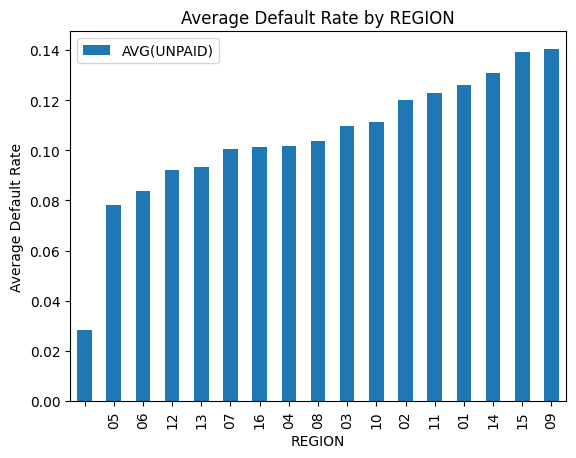

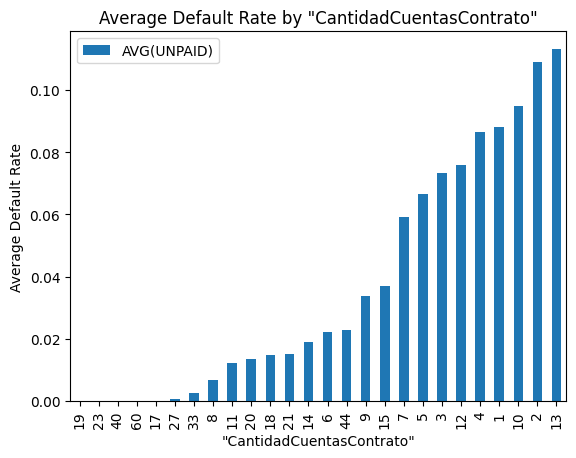

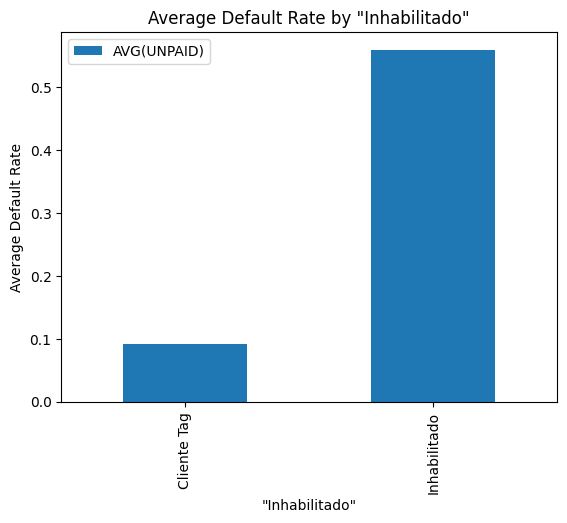

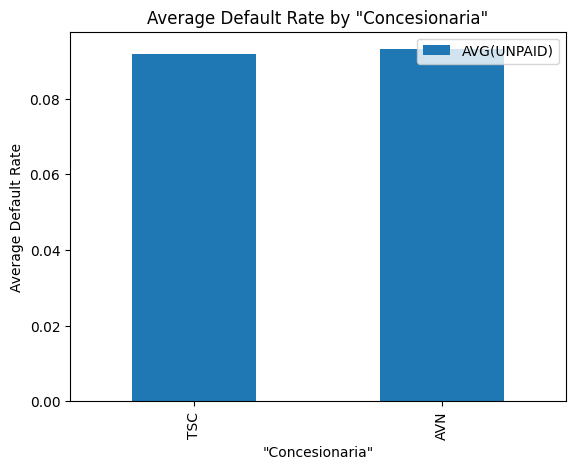

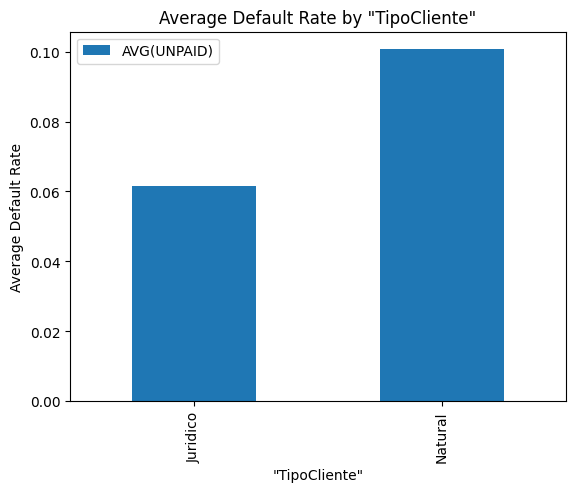

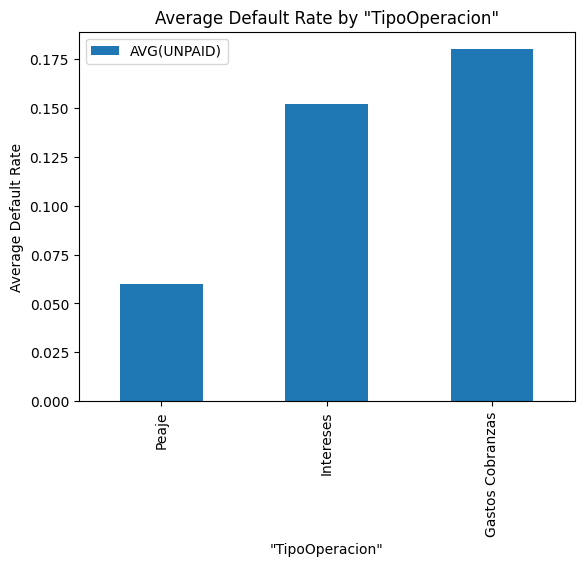

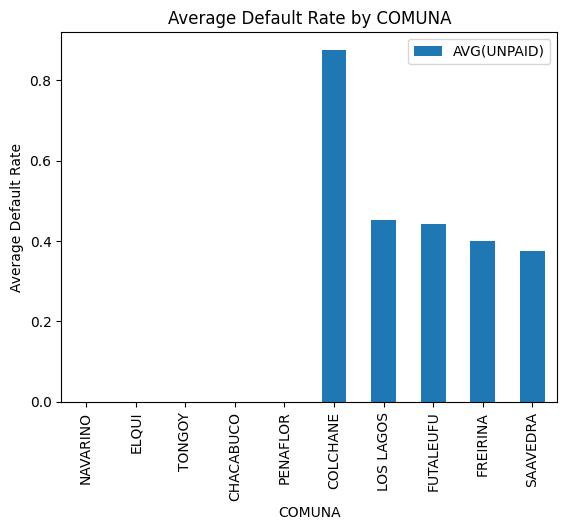

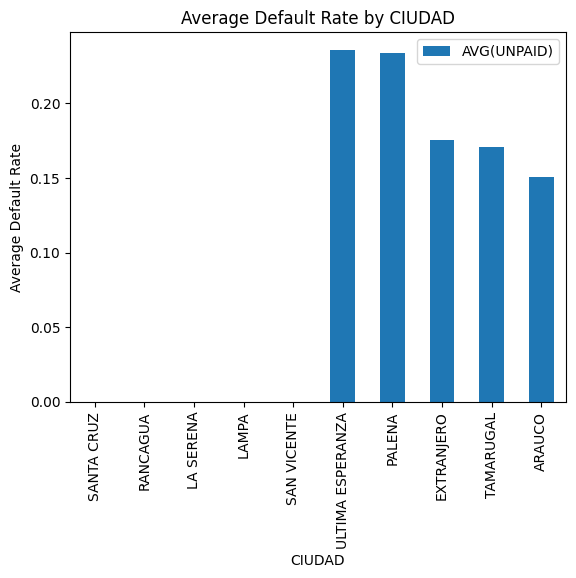

In [ ]:
# Importing necessary library for plotting
import matplotlib.pyplot as plt

# List of variables to create separate graphs
variables = ["REGION", '"CantidadCuentasContrato"',
             '"Inhabilitado"', '"Concesionaria"', '"TipoCliente"', '"TipoOperacion"', "COMUNA", "CIUDAD"]


# Plotting separate bar graphs for each variable
for variable in variables:

    # Group by the variable and calculate the average of 'Unpaid' for each group
    avg_unpaid_by_variable = df_selected_columns.groupBy(variable).agg({'UNPAID': 'mean'})

    # Sorting the values
    avg_unpaid_by_variable = avg_unpaid_by_variable.sort('AVG(UNPAID)')
    if variable == "CIUDAD" or variable == "COMUNA":
        # Convert to Pandas DataFrame and select top and bottom 5 values
        bottom_values = avg_unpaid_by_variable.sort('AVG(UNPAID)', ascending=False).limit(5).toPandas()

        # Convert to Pandas DataFrame and select top and bottom 5 values
        top_values = avg_unpaid_by_variable.limit(5).toPandas()
        bottom_values = avg_unpaid_by_variable.sort('AVG(UNPAID)', ascending=False).limit(5).toPandas()

        # Concatenating top and bottom DataFrames
        selected_values = pd.concat([top_values, bottom_values])
    else :
        selected_values = avg_unpaid_by_variable.toPandas()
    selected_values.set_index(selected_values.columns[0], inplace=True)

    # Plotting the bar graph
    selected_values.plot(kind='bar')
    plt.xlabel(variable)
    plt.ylabel('Average Default Rate')
    plt.title(f'Average Default Rate by {variable}')
    plt.show()

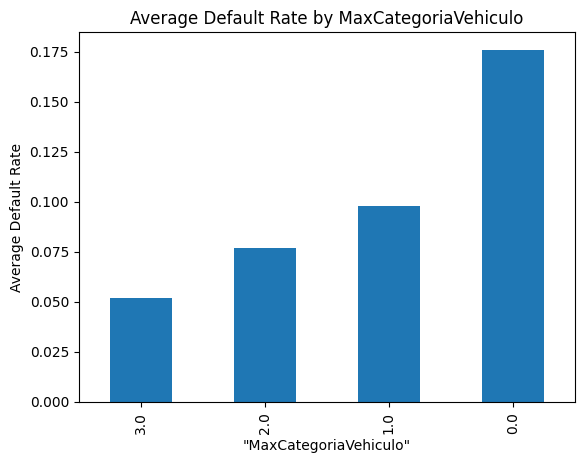

In [ ]:
# List of variables to create separate graphs
variables = ['"MaxCategoriaVehiculo"']


# Plotting separate bar graphs for each variable
for variable in variables:

    # Group by the variable and calculate the average of 'Unpaid' for each group
    avg_unpaid_by_variable = df_selected_columns.groupBy(variable).agg({'UNPAID': 'mean'})

    # Sorting the values
    avg_unpaid_by_variable = avg_unpaid_by_variable.sort('AVG(UNPAID)')
    if variable == "CIUDAD" or variable == "COMUNA":
        # Convert to Pandas DataFrame and select top and bottom 5 values
        bottom_values = avg_unpaid_by_variable.sort('AVG(UNPAID)', ascending=False).limit(5).toPandas()

        # Convert to Pandas DataFrame and select top and bottom 5 values
        top_values = avg_unpaid_by_variable.limit(5).toPandas()
        bottom_values = avg_unpaid_by_variable.sort('AVG(UNPAID)', ascending=False).limit(5).toPandas()

        # Concatenating top and bottom DataFrames
        selected_values = pd.concat([top_values, bottom_values])
    else :
        selected_values = avg_unpaid_by_variable.toPandas()

#grouped_data = selected_values.groupby('MaxCategoriaVehiculo')['AVG(UNPAID)'].mean()
selected_values.set_index(selected_values.columns[0], inplace=True)

# Plotting the grouped data
selected_values.plot(kind='bar', legend=False)
plt.xlabel(variable)
plt.ylabel('Average Default Rate')
plt.title(f'Average Default Rate by MaxCategoriaVehiculo')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
# List of variables to create scatter plots
variables = ["Score Equifax", "ImportePesos", "CantidadVehiculos"]
from sklearn.linear_model import LogisticRegression

# List of continuous variables
continuous_variables = ["Score Equifax", "ImportePesos", "CantidadVehiculos"]
# Drop rows with missing values
df_selected_columns.dropna(subset=continuous_variables + ['Unpaid'], inplace=True)

# Plotting logistic regression for each continuous variable
for variable in continuous_variables:
    # Fitting logistic regression model
    X = df_selected_columns[variable].values.reshape(-1, 1)
    y = df_selected_columns['Unpaid']
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    # Plotting the data points
    sns.scatterplot(x=variable, y='Unpaid', data=df_selected_columns, color='blue')

    # Plotting the logistic regression curve
    sns.lineplot(x=df_selected_columns[variable], y=model.predict_proba(X)[:,1], color='red')

    plt.xlabel(variable)
    plt.ylabel('Probability of Default')
    plt.title(f'Logistic Regression: Probability of Default by {variable}')
    plt.show()

### 1

In [ ]:
invoice_count = df_con_equifax_v_dt.groupBy("YEAR_INVOICED").agg(count("*").alias("invoice_count")).sort("YEAR_INVOICED")

In [ ]:
invoice_count.show(5)

-------------------------------------
|"YEAR_INVOICED"  |"INVOICE_COUNT"  |
-------------------------------------
|2006             |4642068          |
|2007             |6989472          |
|2008             |8816000          |
|2009             |11731024         |
|2010             |11583623         |
-------------------------------------



In [ ]:
invoice_count_df=invoice_count.to_pandas()

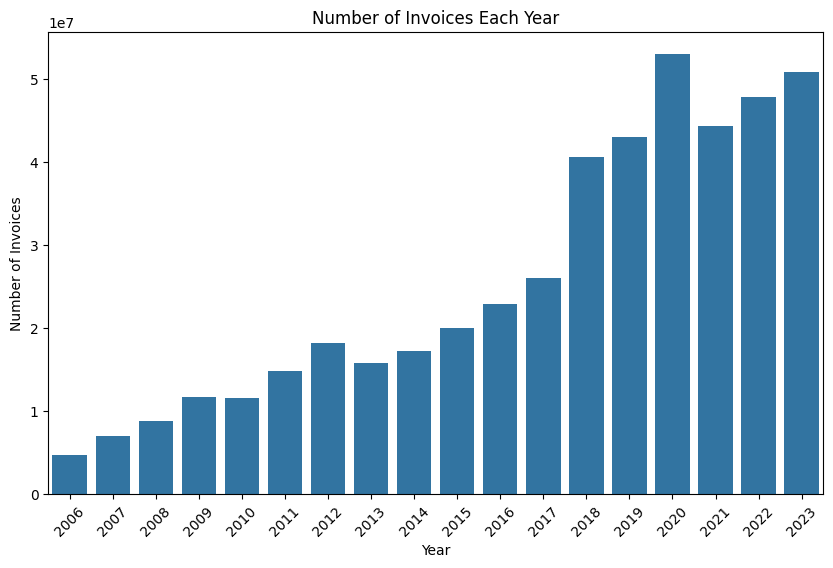

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=invoice_count_df.YEAR_INVOICED, y=invoice_count_df.INVOICE_COUNT)
plt.title('Number of Invoices Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

### 2

In [ ]:
# Group by 'YEAR_INVOICED' and aggregate
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped.show(5)

---------------------------------------------------------------------------
|"YEAR_INVOICED"  |"TOTAL_COUNT"  |"COUNT_DIAS_COMP_LE_0"  |"PERCENTAGE"  |
---------------------------------------------------------------------------
|2017             |25972273       |10130157                |39.003700     |
|2022             |47908312       |19684701                |41.088300     |
|2015             |19999053       |7871247                 |39.358100     |
|2012             |18240328       |6872212                 |37.675900     |
|2009             |11731024       |4885052                 |41.642200     |
---------------------------------------------------------------------------



In [ ]:
grouped_OT_CR=grouped.to_pandas()

In [ ]:
grouped_OT_CR.head()

,YEAR_INVOICED,TOTAL_COUNT,COUNT_DIAS_COMP_LE_0,PERCENTAGE
0,2007,6989472,2516684,36.0068
1,2022,47908312,19684701,41.0883
2,2012,18240328,6872212,37.6759
3,2017,25972273,10130157,39.0037
4,2015,19999053,7871247,39.3581


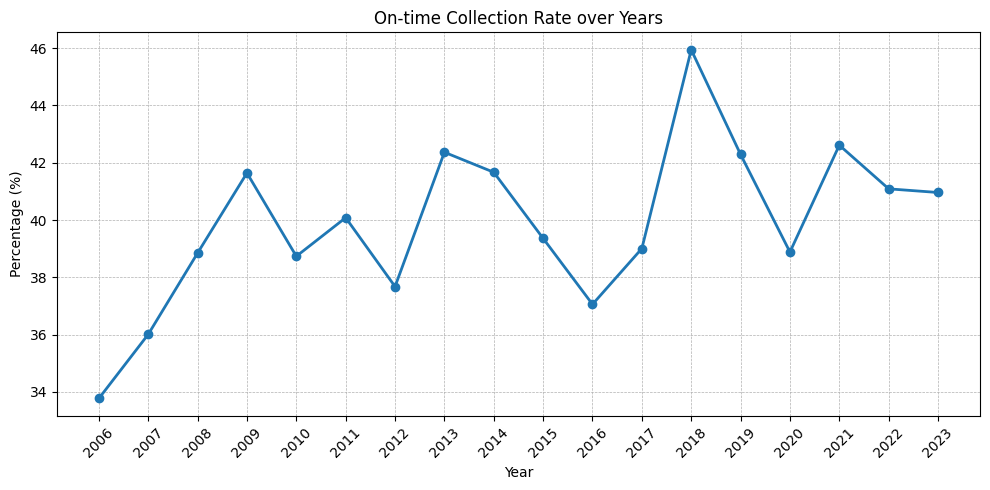

In [ ]:
grouped_OT_CR = grouped_OT_CR.sort_values('YEAR_INVOICED')
# Start the plot
plt.figure(figsize=(10, 5))
plt.plot(grouped_OT_CR['YEAR_INVOICED'], grouped_OT_CR['PERCENTAGE'], marker='o', linewidth=2)  # Added marker and line width

# Set the title and labels
plt.title('On-time Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

# Set x-ticks if 'YEAR_INVOICED' is not the index
plt.xticks(grouped_OT_CR['YEAR_INVOICED'].unique())

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

### 3

In [ ]:
# Group by 'YEAR_INVOICED' and aggregate
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"StatusCompensacion"') =='Pagada', 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_CR=grouped.to_pandas()

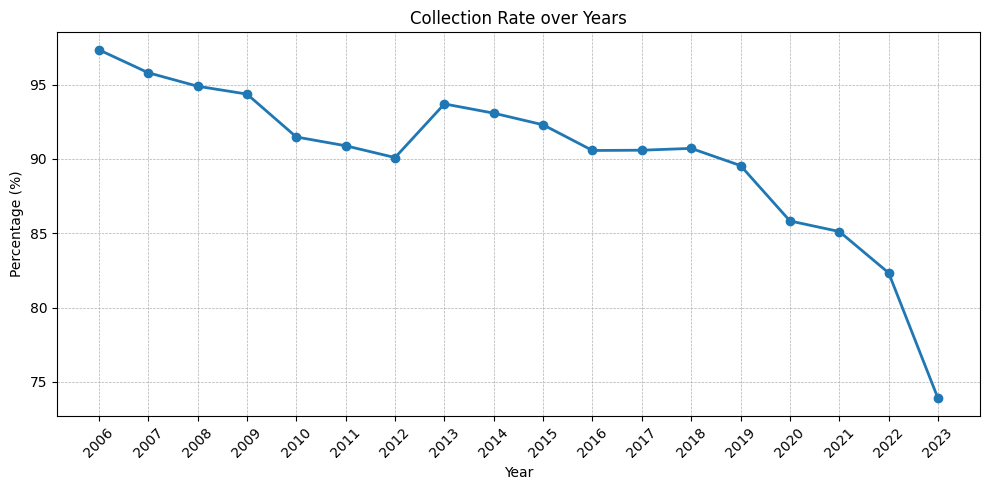

In [ ]:
grouped_OT_CR = grouped_CR.sort_values('YEAR_INVOICED')
# Start the plot
plt.figure(figsize=(10, 5))
plt.plot(grouped_OT_CR['YEAR_INVOICED'], grouped_OT_CR['PERCENTAGE'], marker='o', linewidth=2)  # Added marker and line width

# Set the title and labels
plt.title('Collection Rate over Years')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

# Set x-ticks if 'YEAR_INVOICED' is not the index
plt.xticks(grouped_OT_CR['YEAR_INVOICED'].unique())

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

### 4

In [ ]:
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED'), col('"MaxCategoriaVehiculo"')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_VEH_OT=grouped.to_pandas()

In [ ]:
grouped_VEH_OT.head()

,YEAR_INVOICED,MaxCategoriaVehiculo,TOTAL_COUNT,COUNT_DIAS_COMP_LE_0,PERCENTAGE
0,2017,1.0,20881306,7819932,37.4494
1,2020,1.0,45813611,17605124,38.4277
2,2016,0.0,48794,11234,23.0233
3,2013,0.0,23846,6422,26.9311
4,2008,3.0,802548,299226,37.2845


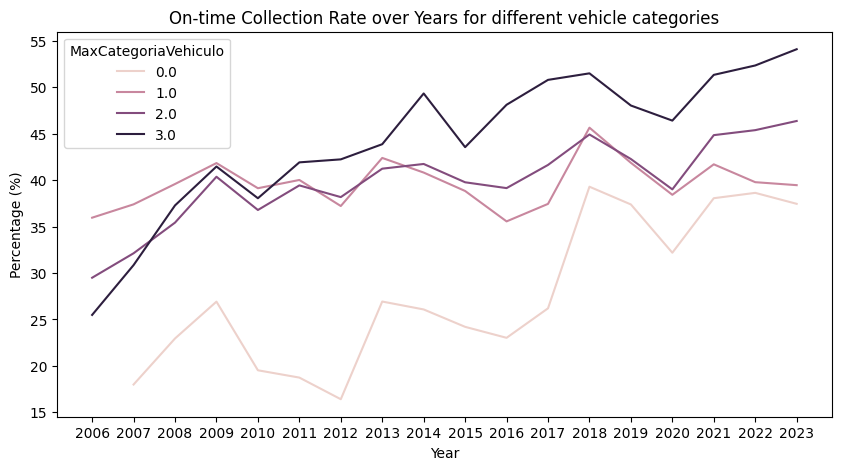

In [ ]:
# grouped.reset_index(inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped_VEH_OT, x='YEAR_INVOICED', y='PERCENTAGE',hue='MaxCategoriaVehiculo')

plt.title('On-time Collection Rate over Years for different vehicle categories')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped_VEH_OT['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

### 5

In [ ]:
from snowflake.snowpark.functions import col, median

df_pagada = df_con_equifax_v_dt.filter(col('"StatusCompensacion"') == 'Pagada')

grouped = df_pagada.groupBy(col('YEAR_INVOICED'), col('"MONTH_INVOICED"')).agg(
    median('"DiasCompensacion"').alias('median_dias_comp')
)
# To display or collect the result
grouped.show()

-----------------------------------------------------------
|"YEAR_INVOICED"  |"MONTH_INVOICED"  |"MEDIAN_DIAS_COMP"  |
-----------------------------------------------------------
|2013             |10                |2.0                 |
|2012             |4                 |5.0                 |
|2007             |5                 |10.0                |
|2023             |6                 |-2.0                |
|2020             |10                |3.0                 |
|2010             |2                 |12.0                |
|2011             |2                 |4.0                 |
|2023             |5                 |-1.0                |
|2013             |5                 |1.0                 |
|2022             |7                 |1.0                 |
-----------------------------------------------------------



In [ ]:
month_df=grouped.to_pandas()

In [ ]:
month_df.sort_values(['YEAR_INVOICED','MONTH_INVOICED'], inplace=True)

In [ ]:
month_df

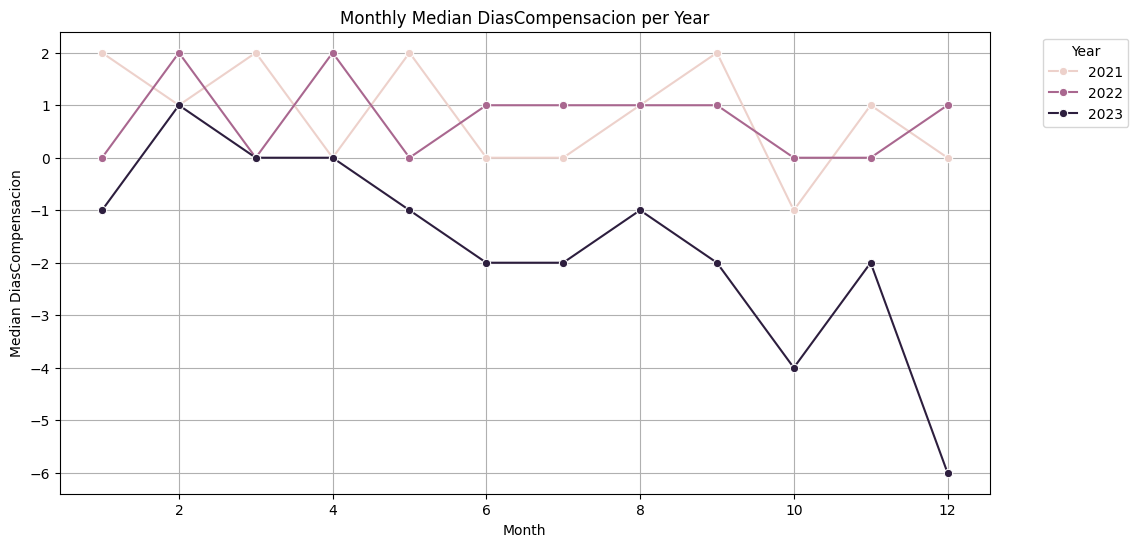

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=month_df[-36:], x='MONTH_INVOICED', y='MEDIAN_DIAS_COMP', hue='YEAR_INVOICED', marker='o')

plt.title('Monthly Median DiasCompensacion per Year')
plt.xlabel('Month')
plt.ylabel('Median DiasCompensacion')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.grid(True)
plt.show()

### 6

In [ ]:
grouped = df_con_equifax_v_dt.groupBy(col('YEAR_INVOICED'), col('"TipoCliente"')).agg(
    count('*').alias('total_count'),
    sum_(when(col('"DiasCompensacion"') <= 0, 1).otherwise(0)).alias('count_dias_comp_le_0')
)

# Calculate the percentage
grouped = grouped.withColumn('percentage', (col('count_dias_comp_le_0') / col('total_count')) * 100)

In [ ]:
grouped_client_type=grouped.to_pandas()

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped_client_type, x='YEAR_INVOICED', y='PERCENTAGE',hue='TipoCliente')

plt.title('On-time Collection Rate over Years for different client categories')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(grouped_client_type['YEAR_INVOICED'].unique())  # Set x-ticks to the unique years
plt.show()

NameError: name 'grouped_client_type' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
total_rows = df_con_equifax_v_dt.count()

# Group by the column and count the occurrences of each unique value
count_distinct_types = df_con_equifax_v_dt.groupBy('"TipoCliente"').agg(count("*").alias("count"))

count_distinct_types = count_distinct_types.withColumn('percentage', (col('count') / lit(total_rows)) * 100)

# Show the results
count_distinct_types.show()